In [3]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /usr/mvl2/llzqd/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [4]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [1]:
import numpy as np
import torch
from torchvision.models.densenet import densenet161
import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
import ISBI_data
from metrics import *
from nets import ResNet, ResNext, ViT, ResNet152, Densenet161, effNetB7, effNetB6
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/usr/mvl2/llzqd/miniconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [23]:
model = ResNext()
# ckpt = torch.load('data/checkpoints/AAR-Loss-ResNext-epoch=025-val_arr=0.00.ckpt', map_location=torch.device('cpu'))
ckpt = torch.load('saved_model/ISBI-WeightedBCE-ResNext101-epoch=013-val_loss=0.0892.ckpt', map_location=torch.device('cpu'))

# # For ResNet
# model = ResNet()
# ckpt = torch.load('data/checkpoints/AAR-Loss-ResNet-epoch=027-val_aar=8.07.ckpt', map_location=torch.device('cpu'))
# ckpt = torch.load('data/checkpoints/MSE-Loss-ResNet-epoch=025-val_aar=7.99.ckpt', map_location=torch.device('cpu'))

new_dict = {k.replace('vit.', 'model.'): v for k, v in ckpt['state_dict'].items()}
model.load_state_dict(new_dict)

# ViT
# model = ViT()
# model.load_from_checkpoint('data/checkpoints/Aligned-VIT-epoch=009-val_arr=7.56.ckpt')

model.eval()
model.cuda()

testing_img_path = '../Test_Set/Test/'
testing_df = '../Test_Set/RFMiD_Testing_Labels.csv'

valset = ISBI_data.ISBIDataset(testing_df, testing_img_path, testing=True)
N = len(valset)
batch_size = 32
dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False, 
                        num_workers=24)

outs = np.zeros((N, 29))
labels = np.zeros((N, 29))
for i, (imgs, label, w) in enumerate(tqdm.tqdm(dataloader)):

    idx = i * batch_size
    imgs = imgs.cuda()
    out = model(imgs).detach().cpu().numpy()
    #out = np.round(out).astype('int').clip(1, None)
    outs[idx:idx + len(out),:] = out
    labels[idx:idx + len(label),:]  = label.detach().cpu().numpy()

100%|██████████| 60/60 [00:24<00:00,  2.44it/s]


In [24]:
def perf_measure(y, y_pred):
    cm = np.zeros((y.shape[1],4))
    for i in range(y.shape[1]):  
        TP = 0
        FP = 0
        TN = 0
        FN = 0 
        for j in range(y.shape[0]): 
            if y_pred[j][i] == 1:
                if y[j][i] == 1:
                    TP+=1
                else:
                    FP+=1
            else:
                if y[j][i] == 0:
                    TN += 1
                else:
                    FN +=1
        cm[i][0] = TP
        cm[i][1] = FP
        cm[i][2] = TN
        cm[i][3] = FN

    return cm

In [26]:
sig = torch.nn.Sigmoid()
rounded_pred = np.round(sig(torch.tensor(outs)).numpy()).astype('int')

In [27]:
cm = perf_measure(labels,rounded_pred)

In [30]:
acc = np.zeros((29,))
err = np.zeros((29,))
for i in range(29):
    acc[i] = cm[i][0]+cm[i][2]
    err[i] = 640-acc[i]

<BarContainer object of 29 artists>

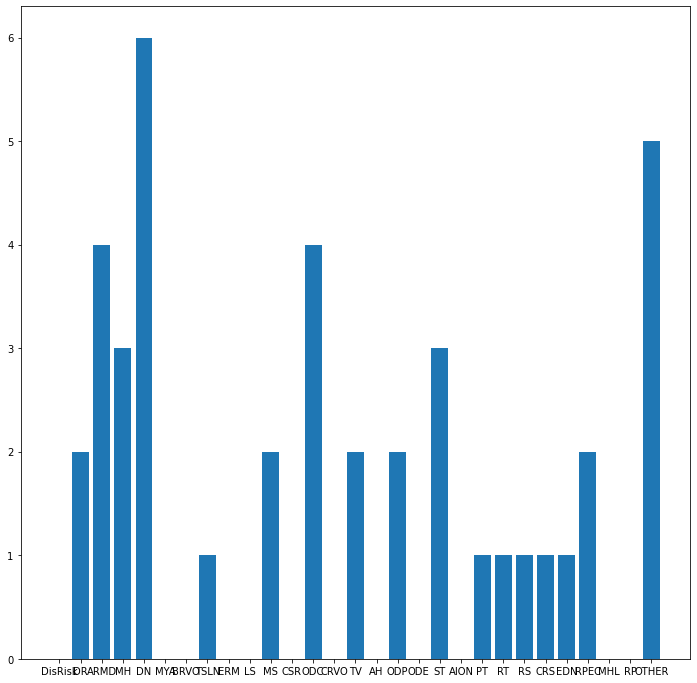

In [31]:
import pandas as pd
df = pd.read_csv('../Training_Set/RFMiD_Training_Labels.csv', header=0)
axis_x = np.array(df.columns[1:])
axis_x[0] = 'DisRisk'
plt.figure(figsize=(12, 12))
plt.bar(axis_x,err)

<BarContainer object of 29 artists>

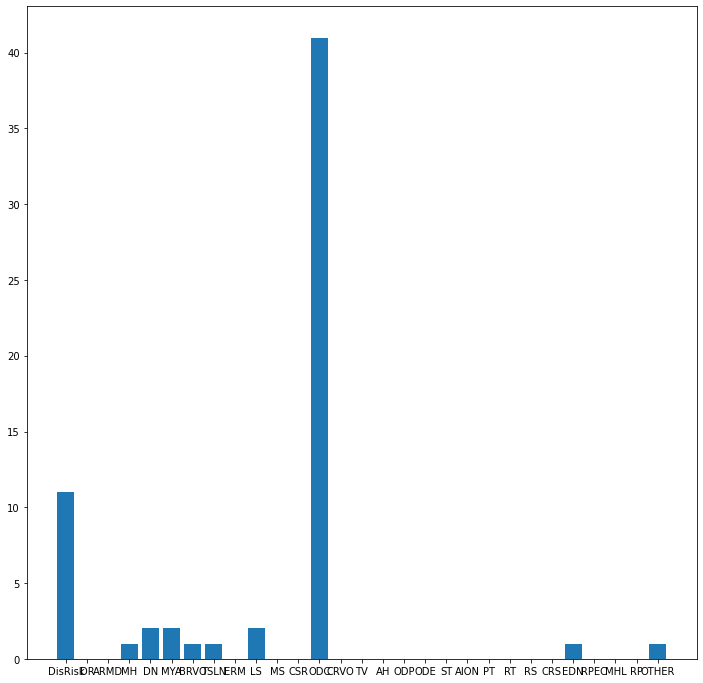

In [15]:
n = 0
l_i = 12
count = np.zeros((labels.shape[1],))
for i in range(labels.shape[0]):
    if(labels[i][l_i]==1 and rounded_pred[i][l_i]==0):
        for j in range(labels.shape[1]):
            if(labels[i][j]!=rounded_pred[i][j] and rounded_pred[i][j]==0):
                count[j]+=1
plt.figure(figsize=(12, 12))
plt.bar(axis_x,count)

In [60]:
n = 0
for i in range(labels.shape[0]):
    if rounded_pred[i][12]==1 and rounded_pred[i][0]==0:
        n+=1
n

2

In [61]:
cm[12]

array([ 43.,  23., 526.,  48.])

In [62]:
count.sum()

138.0

In [75]:
total = 0
for i in range(labels.shape[0]):
    num_per = 0
    lis = []
    for j in [1,3,7,12]:
        if labels[i][j]==1:
            num_per+=1
            lis.append(j)
    if num_per > 1:
        total +=1
        print(lis)
total

[1, 7]
[1, 12]
[1, 12]
[7, 12]
[7, 12]
[7, 12]
[3, 7]
[7, 12]
[3, 7]
[7, 12]
[7, 12]
[7, 12]
[7, 12]
[7, 12]
[7, 12]
[3, 7]
[7, 12]
[3, 12]
[1, 12]
[1, 3]
[7, 12]
[1, 12]
[1, 12]
[3, 12]
[3, 7, 12]
[3, 12]
[1, 7]
[1, 7]
[3, 7]
[1, 3]
[7, 12]
[3, 7]
[1, 7]
[3, 12]
[1, 12]
[3, 12]
[3, 7]
[1, 12]
[1, 12]
[1, 12]
[1, 7, 12]
[1, 12]
[1, 3]
[1, 12]
[1, 12]
[3, 7, 12]
[1, 12]
[1, 12]
[1, 12]
[1, 7]
[3, 12]
[7, 12]
[7, 12]
[3, 7]
[1, 12]
[1, 12]
[1, 12]
[3, 12]
[1, 3, 12]
[1, 7]
[1, 12]
[1, 12]
[1, 7]
[1, 12]
[1, 12]
[1, 12]
[1, 12]
[3, 12]
[3, 12]
[7, 12]
[3, 12]
[3, 12]


72